In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
import pandas as pd
import seaborn as sns

import torch 
from torch.optim import SGD

In [2]:
data = pd.read_csv('wheat.csv')
data['category'] = data['category'].astype(int)
data = data.values

### Model

In [3]:
def softmax(x):
    # x should be of shape (16, 3)
    z = torch.exp(x)
    s = torch.sum(z, axis=1, keepdims=True)
    return z/s

def init_params(num_classes, num_features):
    w = torch.randn((num_features, num_classes), requires_grad=True)
    b = torch.randn((num_classes, ), requires_grad=True)
    return [w, b]

def forward(x, w, b):
    # w - (7, 3), x - (16, 7), b = (3)    
    return softmax(torch.matmul(x, w) + b) # shape will be (16, 3)

def cross_entropy(y, yhat):
    labels = torch.nn.functional.one_hot(y-1, num_classes=3) # shape will be (16, 3)
    return -torch.sum(labels*torch.log(yhat)) # now it will be just sum of all (16, 3) matrix

def accuracy(x, y, params):
    op = forward(x, params[0], params[1]) # shape is (210, 3)
    _, ind = torch.max(op, axis=1)
    return torch.sum(ind==y)/y.shape[0]


In [4]:
def train(dataset, num_epochs, lr, batch_size, params, optimizer):
    w = params[0]
    b = params[1]
    losses =  []
    #data_x = dataset[:, :-1].clone().detach()
    #data_y = dataset[:, -1].clone().detach().to(torch.int)
    data_x = torch.tensor(dataset[:, :-1], dtype=torch.float32)
    data_y = torch.tensor(dataset[:, -1], dtype=int)
    for epoch in range(num_epochs):
        losses.append(cross_entropy(data_y, forward(data_x, w, b)).item()) # this step won't be affective 
        #when the dataset is larger, we can instead do the sum of all the bacthes and take their averages    
        if epoch%(num_epochs/10)==0:
           print(f'epoch {epoch + 1}, loss {float(losses[-1]):f}, accuracy:{accuracy(data_x, data_y-1, params)}')
        #total_loss  =0
        #batches_processed = 0
        for batch in  torch.utils.data.DataLoader(dataset , batch_size=batch_size):
            # shape of w - (7, 5), x - (16, 7), y - (16,) 
            inp = torch.tensor(batch[:, :-1], dtype=torch.float32)
            #print("inp.shape = ", inp.shape)
            label = torch.tensor(batch[:, -1], dtype=int)
           # print("label.shape = ", label.shape)
            op = forward(inp, w, b)
           # print("op.shape = ", op.shape)
          
            
            current_loss = cross_entropy(label, op)
            #total_loss+= current_loss.item()
            
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
            #batches_processed+= 1
    return losses

In [5]:
num_features = 7
num_classes = 3

# params
num_epochs = 1000
batch_size = 16
params = init_params(num_classes, num_features)
lr = 0.001
optimizer = SGD(params=params, lr=lr)

### Fitting the parameters

epoch 1, loss 6591.448242, accuracy:0.3333333432674408
epoch 101, loss 260.747314, accuracy:0.6714285612106323
epoch 201, loss 225.308105, accuracy:0.7190476059913635
epoch 301, loss 202.896362, accuracy:0.7571428418159485
epoch 401, loss 181.986557, accuracy:0.761904776096344
epoch 501, loss 161.955490, accuracy:0.7809523940086365
epoch 601, loss 145.758148, accuracy:0.8047618865966797
epoch 701, loss 133.562027, accuracy:0.8095238208770752
epoch 801, loss 124.422447, accuracy:0.8238095045089722
epoch 901, loss 117.440536, accuracy:0.8238095045089722


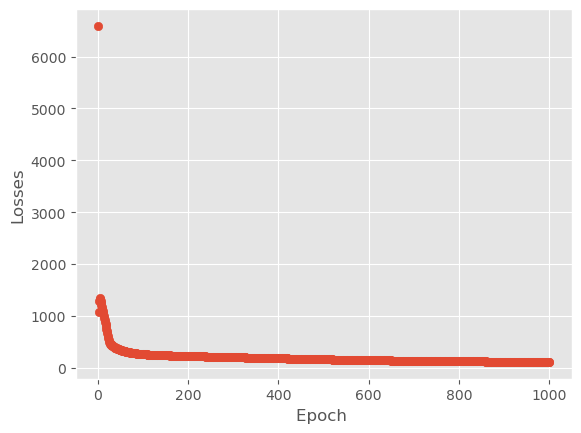

In [6]:
import warnings
warnings.filterwarnings("ignore")
losses = train(dataset=torch.tensor(data, dtype=torch.float32), num_epochs=num_epochs, lr=lr, 
                                batch_size=batch_size, params=params, optimizer=optimizer)            
style.use("ggplot")
plt.scatter(range(1, num_epochs+1), losses)
plt.xlabel("Epoch ")
plt.ylabel("Losses")
#plt.legend()
plt.show()